This notebook is intended for prediciting bike rental count using training data from Kaggle competition as part of project requirement for Spring W207.
Project team: Samantha Brownstein, Mona Gogia, Madison Myers, Ganesh Sundararajan


The Kaggle data can be downloaded from https://www.kaggle.com/c/bike-sharing-demand/data
The data consists of training data as well as test data
The objective is to predict the number of bikes that would be rented based on input variables from the test data.

The format of training data and testdata can be obtained from the above mentioned site.

The Kaggle score will be used as an indicator for the accuracy of the prediction (also to improve our models).  FOr details on how Kaggle score is obtained please refer to https://www.kaggle.com/c/bike-sharing-demand/details/evaluation

In [43]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
#import xlwt
import csv, numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.mixture import GMM



Read the downloaded data (in XLS format) as training data and test data
Prepare the data for initial exploration
The initial exploration involves the following phases
1.  Plot histograms of the the raw data from the training set as well as test data to see how they are distributed
2.  Run some basic exploration regression as well as classification models to see what kind of Kaggle scores we get
3.  Decide on what classifier/regressor gives us the best score


In [44]:
# Training data
train_file  = open('train.csv', "r")
bike_train = csv.reader(train_file)

header_row = True
train_data, train_labels = [], []
for row in bike_train:
    # Save header row.
    if header_row:
        header = row
        header_row = False
    else:
        train_data.append(row)
        train_labels.append(header)

train_data = np.array(train_data)
train_labels = np.array(train_labels)
        
train_file.close()


# Test Data
test_file  = open('test.csv', "r")
bike_test = csv.reader(test_file)
header_row = True
test_data, test_labels = [], []
for row in bike_test:
    # Save header row.
    if header_row:
        header = row
        header_row = False
    else:
        test_data.append(row)
        test_labels.append(header)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
        
test_file.close()

conv_train_data = np.zeros(train_data.shape)

for row in range(0, train_data.shape[0]):
    for col in range(1, train_data.shape[1]):
        conv_train_data[row, col] = train_data[row, col]
        

conv_test_data = np.zeros(test_data.shape)

for row in range(0, test_data.shape[0]):
    for col in range(1, test_data.shape[1]):
        conv_test_data[row, col] = test_data[row, col]
        
# For now remove to data and time
# Also remove the registered and causal columns.  This is for initial exploration
new_train_data = conv_train_data[:, 1:conv_train_data.shape[1]-3]
new_output_data = conv_train_data[:, conv_train_data.shape[1]-1]
new_test_data = conv_test_data[:, 1:conv_test_data.shape[1]]

new_train_labels = train_labels[:, 1:train_labels.shape[1]-3]
new_test_labels = test_labels[:, 1:test_labels.shape[1]]



Plot the training data first to see the distribution
-----------------------------------------------------



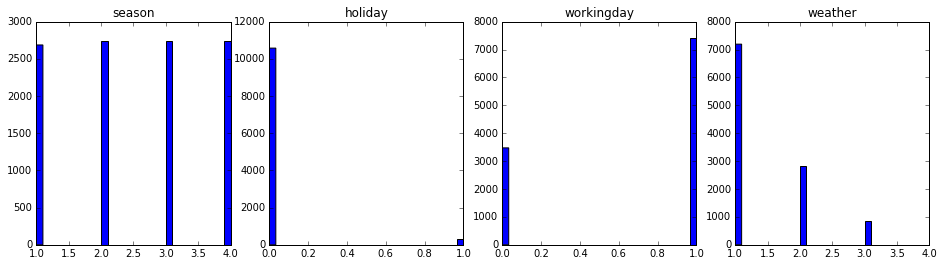

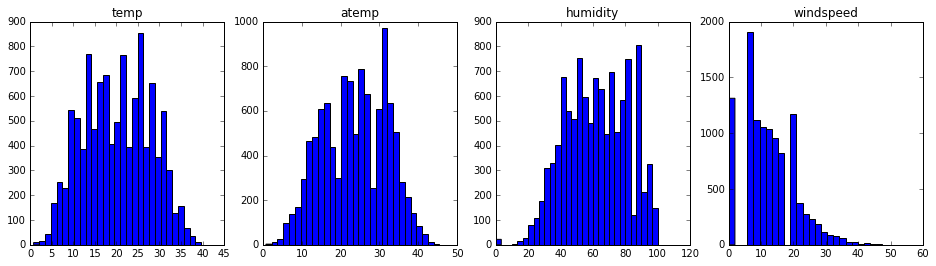

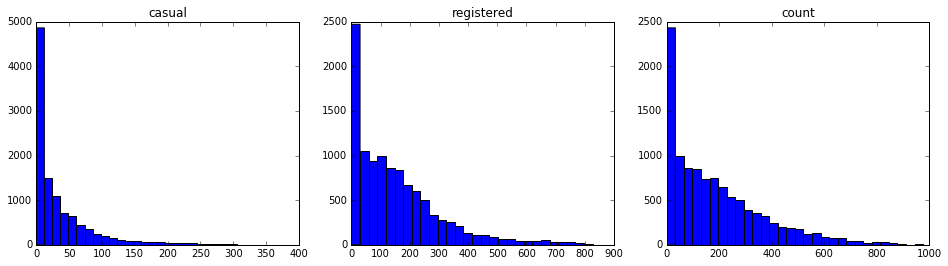

In [45]:
# Training data histogram
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize = (16, 4))

for ii in np.arange(1, 5):
    ax = axes[ii-1]
    ax.hist([int(val) for val in train_data[:,ii]], bins=30) 
    ax.set_title(train_labels[0][ii])

plt.show()

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize = (16, 4))
for ii in np.arange(5, 9):
    ax = axes[ii-5]
    ax.hist([float(val) for val in train_data[:,ii]], bins=30) 
    ax.set_title(train_labels[0][ii])

plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize = (16, 4))
for ii in np.arange(9, 12):
    ax = axes[ii-9]
    ax.hist([float(val) for val in train_data[:,ii]], bins=30) 
    ax.set_title(train_labels[0][ii])

plt.show()

Looking at the plots, it looks like causal and registers are providing more granualar details for prediction rather than just predicting count directly (which we will prove).
The atemp and temp seem to be highly correlated intutively (so only one parameter is needed.  Which we will prove)


Looking at the temp and atemp it looks like binning will help as the count for bins is pretty high.  So intitutively what this means is a difference of 1 or 2 * in the temperature will not make a big difference in people renting bikes.  So we can convert the temp from raw values to bucket values.  We can do the same binning for humidity and windspeed.  

temp, atemp, humidity, windspeed are intutively continous varaibles.  So binning will help in better interpretation

The casual and registered donot look normal.  Lets see if log will work to make them look normal

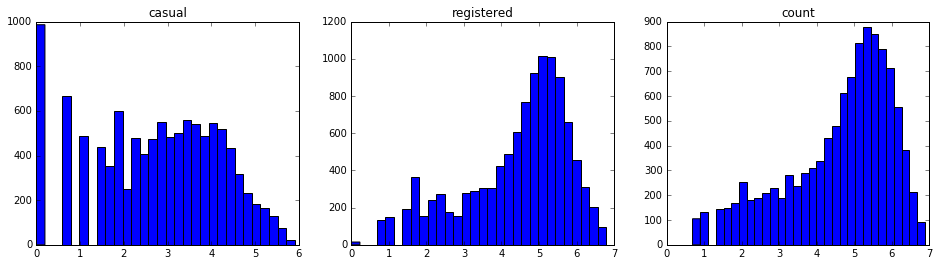

In [46]:


from math import exp, expm1, log

log_output_vars = np.empty( (train_data.shape[0], 3 ))

for i in range (0, train_data.shape[0]):
    log_output_vars[i][0] = log( float(train_data[i][9])+1 ) 
    log_output_vars[i][1] = log( float(train_data[i][10])+1 ) 
    log_output_vars[i][2] = log( float(train_data[i][11])+1 )

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize = (16, 4))
for ii in np.arange(0, 3):
    ax = axes[ii]
    ax.hist([val for val in log_output_vars[:,ii]], bins=30) 
    ax.set_title(train_labels[0][9+ii])



Plot the test data histogram

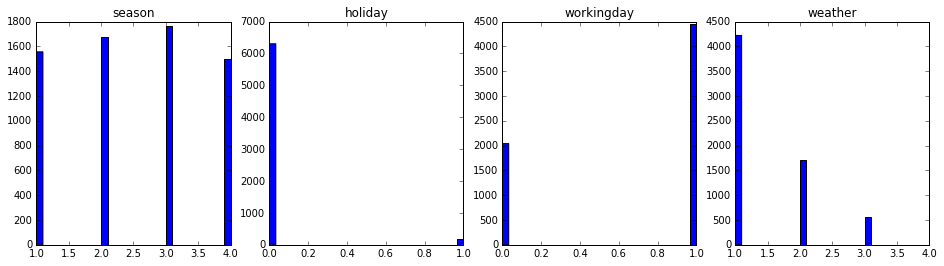

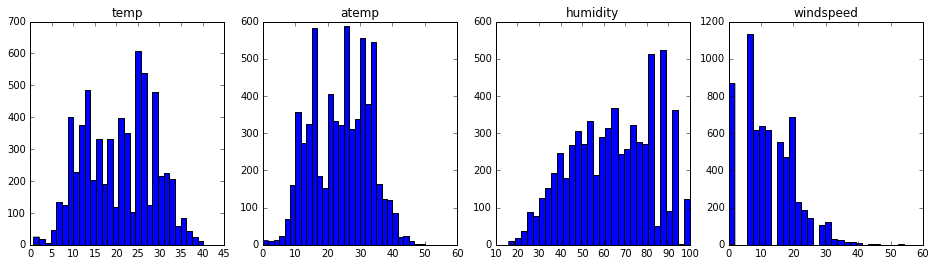

In [47]:
# Test data histogram
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize = (16, 4))

for ii in np.arange(1, 5):
    ax = axes[ii-1]
    ax.hist([int(val) for val in test_data[:,ii]], bins=30) 
    ax.set_title(test_labels[0][ii])

plt.show()

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize = (16, 4))
for ii in np.arange(5, 9):
    ax = axes[ii-5]
    ax.hist([float(val) for val in test_data[:,ii]], bins=30) 
    ax.set_title(test_labels[0][ii])

plt.show()

Exploration Phase
-------------------

We are going to do basic analysis to see what Kaggle scores we get using
1. Linear regression model
   Here we are going to see if we can remove the temp or atemp variable to simplify the model as we have already seen those two    to be highly correlated.
2. kneighbours classifier


In [6]:
lr = LinearRegression(fit_intercept=True)
# Count is the output for which the input is trained
lr.fit(new_train_data, new_output_data) 
lr_preds = lr.predict(new_test_data)

test_lab_f = open("linear_labeled.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0

# We get -ve values.  For now just fix it 0s it is exploration only
for pp in lr_preds:    
    test_lab_f.write("\n")
    if ( pp < 0.0 ):
        pp = 0.0
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# The score returned was 1.43455

Use the linear model to see what scores we get by removing atemp or temp

In [7]:
# It looks like temp and atemp seems to be the same.  Lets try linear model by removing one at a time to see the score
# Remove temp first
mod_train_data = np.delete(new_train_data, np.s_[4], axis=1)
mod_train_labels = np.delete(new_train_labels, np.s_[4], axis=1)
mod_test_data = np.delete(new_test_data, np.s_[4], axis=1)
mod_test_labels = np.delete(new_test_labels, np.s_[4], axis=1)

lr = LinearRegression(fit_intercept=True)
lr.fit(mod_train_data, new_output_data) 
lr_preds = lr.predict(mod_test_data)


test_lab_f = open("linear_labeled_ntemp.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in lr_preds:    
    test_lab_f.write("\n")
    if ( pp < 0.0 ):
        pp = 0.0
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# The score was 1.43445


# Remove atemp 
mod_train_data = np.delete(new_train_data, np.s_[5], axis=1)
mod_train_labels = np.delete(new_train_labels, np.s_[5], axis=1)
mod_test_data = np.delete(new_test_data, np.s_[5], axis=1)
mod_test_labels = np.delete(new_test_labels, np.s_[5], axis=1)

lr = LinearRegression(fit_intercept=True)
# Count is the output for which the input is trained
lr.fit(mod_train_data, new_output_data) 
lr_preds = lr.predict(mod_test_data)

test_lab_f = open("linear_labeled_natemp.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in lr_preds:    
    test_lab_f.write("\n")
    if ( pp < 0.0 ):
        pp = 0.0
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# The score was 1.42884 

# Removing atemp improved the score.  Removing the temp did not make any change to the score.

# So we will go with data without atemp

# The atemp by intution is not a good measure as it is a "feels" like temprature which is not very accurate.


Now do the Kneighbour classifier with the full set.  Also vary the number of neighbors to see if which one gives us better kaggle score

In [8]:
kn = KNeighborsClassifier(n_neighbors=1)

kn.fit(new_train_data, new_output_data)
kn.preds = kn.predict(new_test_data)
#print 'K-Neighbors Prediction'
#print kn.preds

test_lab_f = open("kneigh_labeled.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in kn.preds:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# Score is 1.66165

# Now lets try with the data that got us the lowest linear regresion score
kn = KNeighborsClassifier(n_neighbors=1)

kn.fit(mod_train_data, new_output_data)
kn.preds = kn.predict(mod_test_data)


test_lab_f = open("kneigh_labeled_natemp.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in kn.preds:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# Score is 1.6585

# Now lets vary the n_neightbors

for i in range(2, 4):
    kn = KNeighborsClassifier(n_neighbors=i)

    kn.fit(mod_train_data, new_output_data)
    kn.preds = kn.predict(mod_test_data)


    test_lab_f = open("kneigh_labeled_natemp_"+str(i)+".csv","w")

    test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

    idx = 0
                     
    for pp in kn.preds:    
        test_lab_f.write("\n")
        test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
        idx += 1
   

    test_lab_f.close()  
    
# Neighbors=2, Score 1.76267
# Neighbors=3, Score 1.90713
# The score increases.  So increasing the neighbors not a good idea
    

Now add a few more variables into our preliminary model.  Also include the random forest classifier to see if we get better Kaggle score.

In [9]:
# Now we are going to instrument the date and time 
# Then run the linear regression, kneighbors and random-forest
from datetime import datetime

inst_array = np.empty( (train_data.shape[0], 4) )

for i in range (0, train_data.shape[0]):
    date = datetime.strptime(train_data[i][0], "%Y-%m-%d %H:%M:%S")
    inst_array[i][0] = date.weekday()
    inst_array[i][1] = date.hour
    inst_array[i][2] = date.minute
    inst_array[i][3] = date.second

instrument_train_array = np.concatenate( (inst_array, new_train_data), axis = 1 )

inst_array = np.empty( (test_data.shape[0], 4) )

for i in range (0, test_data.shape[0]):
    date = datetime.strptime(test_data[i][0], "%Y-%m-%d %H:%M:%S")
    inst_array[i][0] = date.weekday()
    inst_array[i][1] = date.hour
    inst_array[i][2] = date.minute
    inst_array[i][3] = date.second    

instrument_test_array = np.concatenate( (inst_array, new_test_data), axis = 1 )


lr = LinearRegression(fit_intercept=True)
lr.fit(instrument_train_array, new_output_data) 
lr_preds = lr.predict(instrument_test_array)


test_lab_f = open("linear_labeled_instrument.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in lr_preds:    
    test_lab_f.write("\n")
    if ( pp < 0.0 ):
        pp = 0.0
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# The score returned was 1.26685

kn = KNeighborsClassifier(n_neighbors=1)

kn.fit(instrument_train_array, new_output_data)
kn.preds = kn.predict(instrument_test_array)

test_lab_f = open("kneigh_labeled_instrument.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in kn.preds:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# test score 0.94964

rf = RandomForestClassifier()

# Train the model
clf = rf.fit(instrument_train_array, new_output_data)
results = clf.predict(instrument_test_array)


test_lab_f = open("rf_vanilla.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()


# Test score rf vanilla = 0.88612

# We are going with random forest classifier

Even though we have determined that removing atemp was a good option, we had still used it.
So run the linear regression, kneighbour as well random forest classifiers without atemp

In [10]:
# Remove atemp as we have determined before that removing atemp makes score better
mod_instrument_train_data = np.delete(instrument_train_array, np.s_[9], axis=1)
mod_instrument_test_data = np.delete(instrument_test_array, np.s_[9], axis=1)

lr = LinearRegression(fit_intercept=True)
# Count is the output for which the input is trained
lr.fit(mod_instrument_train_data, new_output_data) 
lr_preds = lr.predict(mod_instrument_test_data)


test_lab_f = open("linear_labeled_natemp_instrument.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in lr_preds:    
    test_lab_f.write("\n")
    if ( pp < 0.0 ):
        pp = 0.0
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# The score was 1.26607 

kn = KNeighborsClassifier(n_neighbors=1)

kn.fit(mod_instrument_train_data, new_output_data)
kn.preds = kn.predict(mod_instrument_test_data)

test_lab_f = open("kneigh_labeled_natemp_instrument.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in kn.preds:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# test score 0.91618
np.random.seed(415)

rf = RandomForestClassifier()

# Train the model
clf = rf.fit(mod_instrument_train_data, new_output_data)
results = clf.predict(mod_instrument_test_data)


test_lab_f = open("rf_vanilla_natemp.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# Test score rf vanilla = 0.88345

So far we were predicting count as output.  But the training data has broken the count output into registered and casual (added them together to get the count).
We are going to do the same as splitting them intutively will make the classifiers more accurate.

In [11]:
# Instead of predicting count, predict registered and casual.  Then add them to predict the count
registered_output_data = conv_train_data[:, conv_train_data.shape[1]-2]
casual_output_data = conv_train_data[:, conv_train_data.shape[1]-3]

np.random.seed(415)

rf = RandomForestClassifier()

# Train the model
clf = rf.fit(mod_instrument_train_data, registered_output_data)
results_registered = clf.predict(mod_instrument_test_data)

clf = rf.fit(mod_instrument_train_data, casual_output_data)
results_casual = clf.predict(mod_instrument_test_data)

results = np.add(results_registered, results_casual)
test_lab_f = open("rf_split_natemp.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# Score 0.78115


As we saw in the histograms we can do some binning for the temperature, humidity, windspeed
These are continous variables.
Binning them makes their interpretation better for the model.  Ease of interpretation is better for accuracy

In [12]:
bin_train_data = np.empty( (mod_instrument_train_data.shape[0], mod_instrument_train_data.shape[1]) )
bin_test_data = np.empty( (mod_instrument_test_data.shape[0], mod_instrument_test_data.shape[1]) )

bin_train_data[:] = mod_instrument_train_data
bin_test_data[:] = mod_instrument_test_data
# Based on the histogram it looks like we can bin the temp into 6 or 7 bins
train_temp_bin = np.empty( bin_train_data.shape[0] )
for i in range(0, bin_train_data.shape[0]):
    if ( bin_train_data[i][8] < 1.0* 5):
        train_temp_bin[i] = 1 
    elif ( bin_train_data[i][8] < 1.0* 10):
        train_temp_bin[i] = 2 
    elif ( bin_train_data[i][8] < 1.0 * 15):
        train_temp_bin[i] = 3 
    elif ( bin_train_data[i][8] < 1.0 * 20):
        train_temp_bin[i] = 4 
    elif ( bin_train_data[i][8] < 1.0 * 25):
        train_temp_bin[i] = 5         
    elif ( bin_train_data[i][8] < 1.0 * 30):
        train_temp_bin[i] = 6 
    elif ( bin_train_data[i][8] < 1.0 * 35):
        train_temp_bin[i] = 7     
    elif ( bin_train_data[i][8] < 1.0* 40):
        train_temp_bin[i] = 8 
    else:
        train_temp_bin[i] = 9 
# Now replace temp with the binning value in the instrumented array
bin_train_data[:,8] = train_temp_bin

# Do the same for humditity
train_humid_bin = np.empty( bin_train_data.shape[0] )
for i in range(0, bin_train_data.shape[0]):
    if ( bin_train_data[i][9] < 1.0* 10):
        train_humid_bin[i] = 1 
    elif ( bin_train_data[i][9] < 1.0* 20):
        train_humid_bin[i] = 2 
    elif ( bin_train_data[i][9] < 1.0 * 30):
        train_humid_bin[i] = 3 
    elif ( bin_train_data[i][9] < 1.0 * 40):
        train_humid_bin[i] = 4 
    elif ( bin_train_data[i][9] < 1.0 * 50):
        train_humid_bin[i] = 5        
    elif ( bin_train_data[i][9] < 1.0 * 60):
        train_humid_bin[i] = 6 
    elif ( bin_train_data[i][9] < 1.0 * 70):
        train_humid_bin[i] = 7     
    elif ( bin_train_data[i][9] < 1.0* 80):
        train_humid_bin[i] = 8 
    elif ( bin_train_data[i][9] < 1.0* 90):
        train_humid_bin[i] = 9 
    else:
        train_humid_bin[i] = 10   
# Now replace humidity with the binning value in the instrumented array
bin_train_data[:,9] = train_humid_bin

# Do the same for windspeed
train_wind_bin = np.empty( bin_train_data.shape[0] )
for i in range(0, bin_train_data.shape[0]):
    if ( bin_train_data[i][10] < 1.0* 10):
        train_wind_bin[i] = 1 
    elif ( bin_train_data[i][10] < 1.0* 20):
        train_wind_bin[i] = 2 
    elif ( bin_train_data[i][10] < 1.0 * 30):
        train_wind_bin[i] = 3 
    elif ( bin_train_data[i][10] < 1.0 * 40):
        train_wind_bin[i] = 4 
    elif ( bin_train_data[i][10] < 1.0 * 50):
        train_wind_bin[i] = 5         
    elif ( bin_train_data[i][10] < 1.0 * 60):
        train_wind_bin[i] = 6 
    elif ( bin_train_data[i][10] < 1.0 * 70):
        train_wind_bin[i] = 7     
    elif ( bin_train_data[i][10] < 1.0* 80):
        train_wind_bin[i] = 8 
    elif ( bin_train_data[i][10] < 1.0* 90):
        train_wind_bin[i] = 9 
    else:
        train_wind_bin[i] = 10   
# Now replace humidity with the binning value in the instrumented array
bin_train_data[:,10] = train_wind_bin

test_temp_bin = np.empty( bin_test_data.shape[0] )
for i in range(0, bin_test_data.shape[0]):
    if ( bin_test_data[i][8] < 1.0* 5):
        test_temp_bin[i] = 1 
    elif ( bin_test_data[i][8] < 1.0* 10):
        test_temp_bin[i] = 2 
    elif ( bin_test_data[i][8] < 1.0 * 15):
        test_temp_bin[i] = 3 
    elif ( bin_test_data[i][8] < 1.0 * 20):
        test_temp_bin[i] = 4 
    elif ( bin_test_data[i][8] < 1.0 * 25):
        test_temp_bin[i] = 5        
    elif ( bin_test_data[i][8] < 1.0 * 30):
        test_temp_bin[i] = 6 
    elif ( bin_test_data[i][8] < 1.0 * 35):
        test_temp_bin[i] = 7     
    elif ( bin_test_data[i][8] < 1.0* 40):
        test_temp_bin[i] = 8 
    else:
        test_temp_bin[i] = 9   
# Now replace temp with the binning value in the instrumented array
bin_test_data[:,8] = test_temp_bin

# Do the same for humditity
test_humid_bin = np.empty( bin_test_data.shape[0] )
for i in range(0, bin_test_data.shape[0]):
    if ( bin_test_data[i][9] < 1.0* 10):
        test_humid_bin[i] = 1 
    elif ( bin_test_data[i][9] < 1.0* 20):
        test_humid_bin[i] = 2 
    elif ( bin_test_data[i][9] < 1.0 * 30):
        test_humid_bin[i] = 3 
    elif ( bin_test_data[i][9] < 1.0 * 40):
        test_humid_bin[i] = 4 
    elif ( bin_test_data[i][9] < 1.0 * 50):
        test_humid_bin[i] = 5         
    elif ( bin_test_data[i][9] < 1.0 * 60):
        test_humid_bin[i] = 6 
    elif ( bin_test_data[i][9] < 1.0 * 70):
        test_humid_bin[i] = 7     
    elif ( bin_test_data[i][9] < 1.0* 80):
        test_humid_bin[i] = 8 
    elif ( bin_test_data[i][9] < 1.0* 90):
        test_humid_bin[i] = 9 
    else:
        test_humid_bin[i] = 10   
# Now replace humidity with the binning value in the instrumented array
bin_test_data[:,9] = test_humid_bin

# Do the same for windspeed
test_wind_bin = np.empty( bin_test_data.shape[0] )
for i in range(0, bin_test_data.shape[0]):
    if ( bin_test_data[i][10] < 1.0* 10):
        test_wind_bin[i] = 1 
    elif ( bin_test_data[i][10] < 1.0* 20):
        test_wind_bin[i] = 2 
    elif ( bin_test_data[i][10] < 1.0 * 30):
        test_wind_bin[i] = 3 
    elif ( bin_test_data[i][10] < 1.0 * 40):
        test_wind_bin[i] = 4 
    elif ( bin_test_data[i][10] < 1.0 * 50):
        test_wind_bin[i] = 5         
    elif ( bin_test_data[i][10] < 1.0 * 60):
        test_wind_bin[i] = 6 
    elif ( bin_test_data[i][10] < 1.0 * 70):
        test_wind_bin[i] = 7    
    elif ( bin_test_data[i][10] < 1.0* 80):
        test_wind_bin[i] = 8 
    elif ( bin_test_data[i][10] < 1.0* 90):
        test_wind_bin[i] = 9 
    else:
        test_wind_bin[i] = 10   
# Now replace windspeed with the binning value in the instrumented array
bin_test_data[:,10] = test_wind_bin

In [50]:
# Now run the RF CLF

np.random.seed(415)

rf = RandomForestClassifier()

# Train the model
clf = rf.fit(bin_train_data, registered_output_data)
results_registered = clf.predict(bin_test_data)

clf = rf.fit(bin_train_data, casual_output_data)
results_casual = clf.predict(bin_test_data)

results = np.add(results_registered, results_casual)
test_lab_f = open("rf_bin_temp.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# Score 0.67546 




In [48]:
# When looking at the holiday vs working it is not very apparent what is the weekend effect as intution says weekend will have more count than
# weekday.  So lets instrument that as well
week_train_data = np.empty( (bin_train_data.shape[0], bin_train_data.shape[1]+1))
weekend_train = np.empty( (bin_train_data.shape[0], 1 ))
for i in range(0, bin_train_data.shape[0]):
    if ( bin_train_data[i][0] > 4 ):
        weekend_train[i] = 1 
    else:
        weekend_train[i] = 0 

week_train_data = np.concatenate( (bin_train_data, weekend_train), axis = 1 )


week_test_data = np.empty( (bin_test_data.shape[0], bin_test_data.shape[1]+1))
weekend_test = np.empty( (bin_test_data.shape[0], 1) )
for i in range(0, bin_test_data.shape[0]):
    if ( bin_test_data[i][0] > 4 ):
        weekend_test[i] = 1 
    else:
        weekend_test[i] = 0 
        
week_test_data = np.concatenate( (bin_test_data, weekend_test), axis = 1 )

# Now run the RCLF

np.random.seed(415)

rf = RandomForestClassifier()

clf = rf.fit(week_train_data, casual_output_data)
results_casual = clf.predict(week_test_data)

clf = rf.fit(week_train_data, registered_output_data)
results_registered = clf.predict(week_test_data)

results = np.add(results_registered, results_casual)
test_lab_f = open("rf_week_temp.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# Score 0.65737 




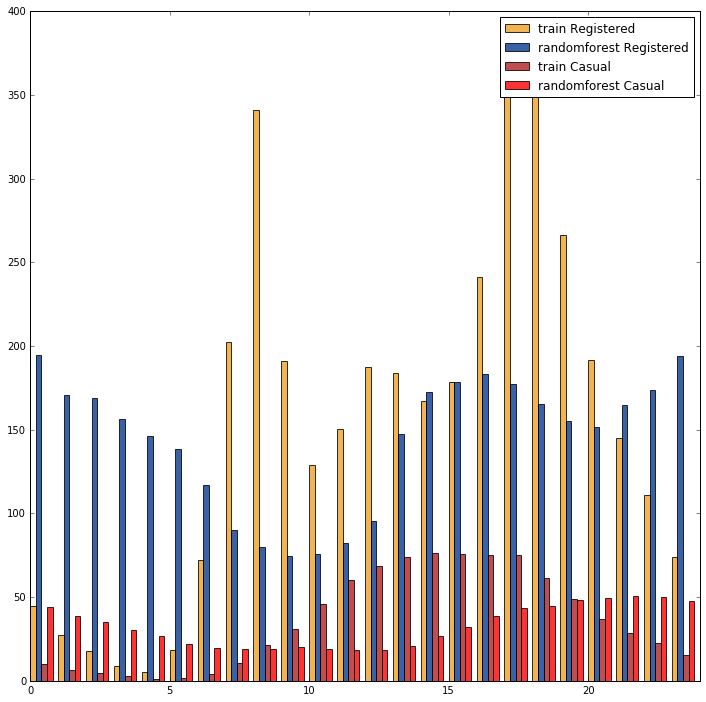

In [49]:
#create new variable for hour
hour = np.zeros(train_data.shape[0])

for i in range(train_data[:,0].shape[0]):
    date = datetime.strptime(train_data[i][0], "%Y-%m-%d %H:%M:%S")
    hour[i] = date.hour

#define a function to 'roll up' data (like excel pivot table)    
def summarize(preds):
    averages = np.empty([24,])
    for i in range(24):
        count = 0
        n = 0
        for h in range(preds.shape[0]):
            if hour[h] == i:
                count += preds[h]
                n += 1
        averages[i] = count/n
    return averages


plt.figure(figsize=(12,12))
plt.xlim(0,24)
bar_width = 0.2
opacity = 0.8

def width_adjust(x):
    x_adjust = []    
    for i in range(24):
        x_adjust.append(hour[i] + x)
    return x_adjust

# Split the charts into two.  One for registered and another for casual so that we can see how our prediction follows the training set
bars_train_reg = plt.bar(set(hour), summarize(conv_train_data[:,-2]), bar_width,
                 alpha=opacity,
                 color='#efa028',
                 label='train Registered')

bars_rf_reg = plt.bar(width_adjust(1*bar_width), summarize(results_registered), bar_width,
                 alpha=opacity,
                 color='#073a93',
                 label='randomforest Registered')

bars_train_cas = plt.bar(width_adjust(2*bar_width), summarize(conv_train_data[:,-3]), bar_width,
                 alpha=opacity,
                 color='#B22222',
                 label='train Casual')

bars_rf_cas = plt.bar(width_adjust(3*bar_width), summarize(results_casual), bar_width,
                 alpha=opacity,
                 color='#FF0000',
                 label='randomforest Casual')

plt.legend()



In [51]:
# It is getting more clear that during the mid-day the prediction follows the train data shape.  But 
# during the early and late hours the trend between the training and predicted is way off
# The training data trend seems to indicate some kind of bunching
# It looks like early morning hours dont hae signficant activity from 0 -> 4 
# Same way 22 -> 23 shows decreasing trend
# Activity starts picking up at 5->8.  So we will separate them out
# 18, 19 also show some major activity
# 20, 21 -> Start a downward trend.  So lets bunch them together
# 17 shows a major increase.  So we separate it out
# This whole inference is very subject.  There must be a better way
day_train_data = np.empty( (week_train_data.shape[0], week_train_data.shape[1]+1))
day_bin = np.empty( (week_train_data.shape[0], 1) )
for i in range(0, week_train_data.shape[0]):
    # 0 -> 4
    if ( week_train_data[i][1] < 1.0 * 5):
        day_bin[i] = 1 
    # 5 -> 8
    elif ( week_train_data[i][1] < 1.0 * 9):
        day_bin[i] = 2  
    # 9
    elif ( week_train_data[i][1] < 1.0 * 10):
        day_bin[i] = 3 
    # 10 -> 16
    elif ( week_train_data[i][1] < 1.0 * 17):
        day_bin[i] = 4        
    # 17
    elif ( week_train_data[i][1] < 1.0 * 18):
        day_bin[i] = 5 
    # 18, 19
    elif ( week_train_data[i][1] < 1.0 * 20):
        day_bin[i] = 6 
    # 20 , 21
    elif ( week_train_data[i][1] < 1.0 * 22):
        day_bin[i] = 7 
    # 22, 23
    else:
        day_bin[i] = 8  
# Now concatenate with the binning value in the instrumented array
day_train_data = np.concatenate( (week_train_data, day_bin), axis = 1 )


day_test_data = np.empty( (week_test_data.shape[0], week_test_data.shape[1]+1))
day_bin = np.empty( (week_test_data.shape[0], 1) )
for i in range(0, week_test_data.shape[0]):
    if ( week_test_data[i][1] < 1.0 * 5):
        day_bin[i] = 1 
    elif ( week_test_data[i][1] < 1.0 * 9):
        day_bin[i] = 2 
    elif ( week_test_data[i][1] < 1.0 * 10):
        day_bin[i] = 3 
    elif ( week_test_data[i][1] < 1.0 * 17):
        day_bin[i] = 4 
    elif ( week_test_data[i][1] < 1.0 * 18):
        day_bin[i] = 5        
    elif ( week_test_data[i][1] < 1.0 * 20):
        day_bin[i] = 6 
    elif ( week_test_data[i][1] < 1.0 * 22):
        day_bin[i] = 7         
    else:
        day_bin[i] = 8   
day_test_data = np.concatenate( (week_test_data, day_bin), axis = 1 )


# Now run the RCLF

np.random.seed(300)

rf = RandomForestClassifier()

clf = rf.fit(day_train_data, casual_output_data)
results_casual = clf.predict(day_test_data)

clf = rf.fit(day_train_data, registered_output_data)
results_registered = clf.predict(day_test_data)

results = np.add(results_registered, results_casual)
test_lab_f = open("rf_day.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# Score 0.59398



So far we have assumed that the 2011 and 2012 years are basically the same.  We never checked if they are.  So lets plot the average count of each month for both years to see they are the same.

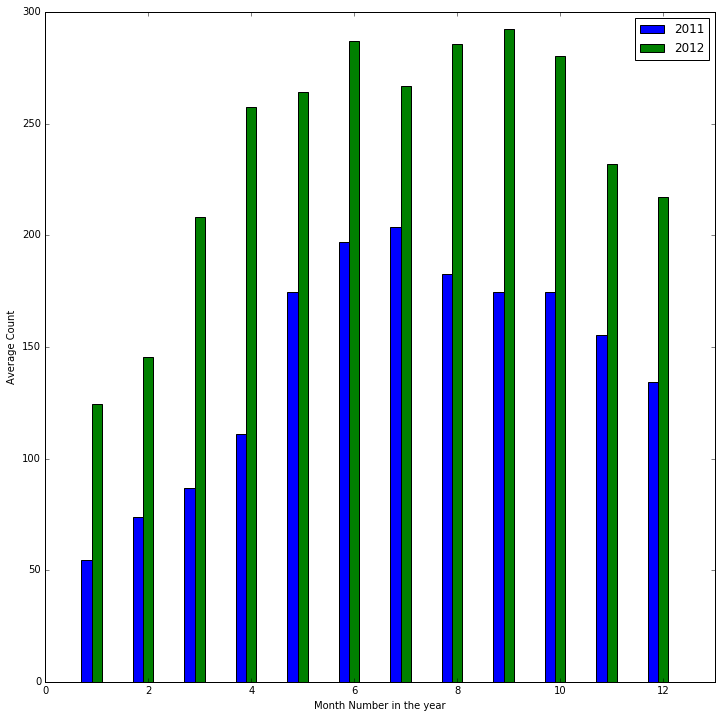

In [28]:
# See the trend on a monthly basis between 2011 and 2012
month = np.zeros(train_data.shape[0])
year = np.zeros(train_data.shape[0])

# Extract the years and months
for i in range(train_data[:,0].shape[0]):
    date = datetime.strptime(train_data[i][0], "%Y-%m-%d %H:%M:%S")
    month[i] = date.month
    year[i] = date.year
    
count_11 = 0 ;
count_12 = 0 ;
for i in range(year.shape[0]):
        if ( year[i] == 2011.0 ):
            count_11 += 1
        else:
            count_12 += 1
            
output_by_2011 = np.zeros( (count_11, ) )
output_by_2012 = np.zeros( (count_12, ) )
month_by_2011 = np.zeros( (count_11, ) )
month_by_2012 = np.zeros( (count_12, ) )

run_11 = 0 
run_12 = 0 
for i in range(year.shape[0]):
        if ( year[i] == 2011.0 ):
            output_by_2011[run_11] = new_output_data[i]
            month_by_2011[run_11] = month[i]
            run_11 += 1
        else:
            output_by_2012[run_12] = new_output_data[i]
            month_by_2012[run_12] = month[i]
            run_12 += 1    
            
#define a function to 'roll up' data (like excel pivot table)    
def summarize(preds, month):
    averages = np.empty([12,])
    for i in range(1, 13):
        count = 0
        n = 0
        for h in range(preds.shape[0]):
            if month[h] == i:
                count += preds[h]
                n += 1
        averages[i-1] = count/n
    return averages

plt.figure(figsize=(12,12))
plt.xlim(0,13)


def width_adjust(x, month):
    x_adjust = []    
    for i in range(12):
        x_adjust.append(month[i] + x)
    return x_adjust



ax = plt.subplot(111)
ax.set_xlabel('Month Number in the year')
ax.set_ylabel('Average Count')
b_2011 = ax.bar(np.array(list(set(month_by_2011))) - 0.2, summarize(output_by_2011, month_by_2011),width=0.2,color='b',align='center', label='2011')
b_2012 = ax.bar(np.array(list(set(month_by_2011))), summarize(output_by_2012, month_by_2012),width=0.2,color='g',align='center', label='2012')



plt.legend(handles=[b_2011, b_2012])


plt.show()

  


The trend clearly shows an increase in count across all months
So we need to instrument the year and month also as one of the variables

          

In [52]:
# The array we have so far is the follows
# 0 -> Weekday instrumented
# 1 -> Hour instrumented
# 2 -> Minute instrumented
# 3 -> Seconds instrumented
# 4 -> Season
# 5 -> Holiday
# 6 -> Working Day
# 7 -> Weather
# 8 -> Temp binned
# 9 -> Humidity binned
# 10 -> windspeed binned
# 11 -> Weekend instrumented
# 12 -> day binned


# Lets add the month and year also
ym_train_data = np.empty( (day_train_data.shape[0], day_train_data.shape[1]+2))
ym_array = np.empty( (day_train_data.shape[0], 2) )
for i in range(ym_array.shape[0]):
    date = datetime.strptime(train_data[i][0], "%Y-%m-%d %H:%M:%S")
    ym_array[i][0] = date.year
    ym_array[i][1] = date.month
ym_train_data = np.concatenate( (day_train_data, ym_array), axis = 1 )       

ym_test_data = np.empty( (day_test_data.shape[0], day_test_data.shape[1]+2))
ym_array = np.empty( (day_test_data.shape[0], 2) )
for i in range(ym_array.shape[0]):
    date = datetime.strptime(test_data[i][0], "%Y-%m-%d %H:%M:%S")
    ym_array[i][0] = date.year
    ym_array[i][1] = date.month
ym_test_data = np.concatenate( (day_test_data, ym_array), axis = 1 ) 

# The array we have so far is the follows
# 0 -> Weekday instrumented
# 1 -> Hour instrumented
# 2 -> Minute instrumented
# 3 -> Seconds instrumented
# 4 -> Season
# 5 -> Holiday
# 6 -> Working Day
# 7 -> Weather
# 8 -> Temp binned
# 9 -> Humidity binned
# 10 -> windspeed binned
# 11 -> Weekend instrumented
# 12 -> day binned
# 13 -> Year
# 14 -> Month

# Now run the RCLF

np.random.seed(300)

rf = RandomForestClassifier()

clf = rf.fit(ym_train_data, casual_output_data)
results_casual = clf.predict(ym_test_data)

clf = rf.fit(ym_train_data, registered_output_data)
results_registered = clf.predict(ym_test_data)

results = np.add(results_registered, results_casual)
test_lab_f = open("rf_ym.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# Score 0.60964





Lets do one more instrumentation.  Looking at the data between training and test, we have assumed that season variable 
will follow the exact quarters in an year.  But looking at the raw data that is not the case.  So lets created a instrumented variable that identifies quarters in an year.  

In [53]:
# The array we have so far is the follows
# 0 -> Weekday instrumented
# 1 -> Hour instrumented
# 2 -> Minute instrumented
# 3 -> Seconds instrumented
# 4 -> Season
# 5 -> Holiday
# 6 -> Working Day
# 7 -> Weather
# 8 -> Temp binned
# 9 -> Humidity binned
# 10 -> windspeed binned
# 11 -> Weekend instrumented
# 12 -> day binned
# 13 -> Year
# 14 -> Month

# Now lets convert the months to quaters
qrt_train_data = np.empty( (ym_train_data.shape[0], ym_train_data.shape[1]+1))
qrt_array = np.empty( (ym_train_data.shape[0], 1) )
for i in range(qrt_array.shape[0]):
        date = datetime.strptime(train_data[i][0], "%Y-%m-%d %H:%M:%S")
        if ( date.month < 4 ):
            qrt_array[i] = 1 
        elif (date.month < 7):
            qrt_array[i] = 2 
        elif (date.month < 10):
            qrt_array[i] = 3 
        else:
            qrt_array[i] = 4 
qrt_train_data = np.concatenate( (ym_train_data, qrt_array), axis = 1 )       

qrt_test_data = np.empty( (ym_test_data.shape[0], ym_test_data.shape[1]+1))
qrt_array = np.empty( (ym_test_data.shape[0], 1) )
for i in range(qrt_array.shape[0]):
        date = datetime.strptime(test_data[i][0], "%Y-%m-%d %H:%M:%S")
        if ( date.month < 4 ):
            qrt_array[i] = 1 
        elif (date.month < 7):
            qrt_array[i] = 2 
        elif (date.month < 10):
            qrt_array[i] = 3 
        else:
            qrt_array[i] = 4 
qrt_test_data = np.concatenate( (ym_test_data, qrt_array), axis = 1 )       



# The array we have so far is the follows
# 0 -> Weekday instrumented
# 1 -> Hour instrumented
# 2 -> Minute instrumented
# 3 -> Seconds instrumented
# 4 -> Season
# 5 -> Holiday
# 6 -> Working Day
# 7 -> Weather
# 8 -> Temp binned
# 9 -> Humidity binned
# 10 -> windspeed binned
# 11 -> Weekend instrumented
# 12 -> day binned
# 13 -> Year
# 14 -> Month
# 15 -> Instrumented quarter

# Now run the RCLF

np.random.seed(300)

rf = RandomForestClassifier()

clf = rf.fit(qrt_train_data, casual_output_data)
results_casual = clf.predict(qrt_test_data)

clf = rf.fit(qrt_train_data, registered_output_data)
results_registered = clf.predict(qrt_test_data)

results = np.add(results_registered, results_casual)
test_lab_f = open("rf_qrt.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# Score 0.58120




We have done all the instrumentation we can with the classifier.  So lets jump on to the regressor as we know that our problem 
is a regression problem.
We will use SVM regressor to see what kind of score we get.  Since we have used RF classifier, we donot expect great improvement using 
random forest regressor.


In [54]:
from sklearn import svm

np.random.seed(300)


rf = svm.SVR()

clf = rf.fit(qrt_train_data, log_output_vars[:,0])
results_casual_log = clf.predict(qrt_test_data)

clf = rf.fit(qrt_train_data, log_output_vars[:,1])
results_registered_log = clf.predict(qrt_test_data)

results_casual = np.empty(results_casual_log.shape)
results_registered = np.empty(results_registered_log.shape)

for i in range(results_casual_log.shape[0]):
    results_casual[i] = expm1(results_casual_log[i])
    results_registered[i] = expm1(results_registered_log[i])

results = np.add(results_registered, results_casual)
test_lab_f = open("svm_qrt_log.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# Score .44726



Lets plot so see how well we did

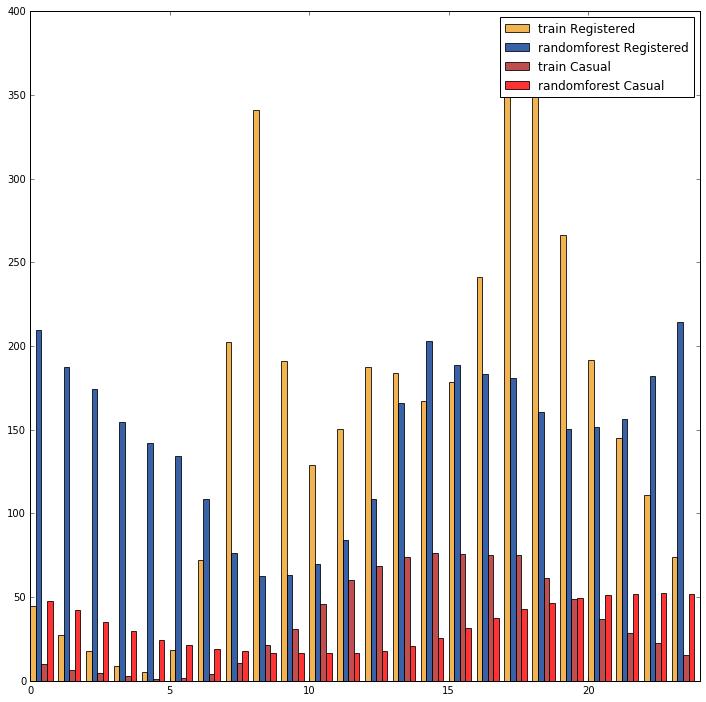

In [55]:

hour = np.zeros(train_data.shape[0])

for i in range(train_data[:,0].shape[0]):
    date = datetime.strptime(train_data[i][0], "%Y-%m-%d %H:%M:%S")
    hour[i] = date.hour

#define a function to 'roll up' data (like excel pivot table)    
def summarize(preds):
    averages = np.empty([24,])
    for i in range(24):
        count = 0
        n = 0
        for h in range(preds.shape[0]):
            if hour[h] == i:
                count += preds[h]
                n += 1
        averages[i] = count/n
    return averages


plt.figure(figsize=(12,12))
plt.xlim(0,24)
bar_width = 0.2
opacity = 0.8

def width_adjust(x):
    x_adjust = []    
    for i in range(24):
        x_adjust.append(hour[i] + x)
    return x_adjust

# Split the charts into two.  One for registered and another for casual so that we can see how our prediction follows the training set
bars_train_reg = plt.bar(set(hour), summarize(conv_train_data[:,-2]), bar_width,
                 alpha=opacity,
                 color='#efa028',
                 label='train Registered')

bars_rf_reg = plt.bar(width_adjust(1*bar_width), summarize(results_registered), bar_width,
                 alpha=opacity,
                 color='#073a93',
                 label='randomforest Registered')

bars_train_cas = plt.bar(width_adjust(2*bar_width), summarize(conv_train_data[:,-3]), bar_width,
                 alpha=opacity,
                 color='#B22222',
                 label='train Casual')

bars_rf_cas = plt.bar(width_adjust(3*bar_width), summarize(results_casual), bar_width,
                 alpha=opacity,
                 color='#FF0000',
                 label='randomforest Casual')

plt.legend()


Lets run a few more regressors to conclude SVM regressor is the best
We are going to run the linear regression, lasso and ridge for comparison purpose

In [56]:
from sklearn import linear_model


rdg= linear_model.Ridge (alpha = .5)
clf = rdg.fit(qrt_train_data, 
              log_output_vars[:,0])
results_casual_log = rdg.predict(qrt_test_data)

clf = rdg.fit(qrt_train_data, log_output_vars[:,1])
results_registered_log = rdg.predict(qrt_test_data)


results_casual = np.empty(results_casual_log.shape)
results_registered = np.empty(results_registered_log.shape)

for i in range(results_casual_log.shape[0]):
    results_casual[i] = expm1(results_casual_log[i])
    results_registered[i] = expm1(results_registered_log[i])

#results_casual = [expm1(el) for el in results_casual_log]
#results_registered = [expm1(el) for el in results_registered_log]



results = np.add(results_registered, results_casual)
test_lab_f = open("rdg_qrt_log.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# 1.02599



In [57]:
lasso = linear_model.Lasso(alpha = 0.1)

clf = lasso.fit(qrt_train_data, 
              log_output_vars[:,0])
results_casual_log = lasso.predict(qrt_test_data)

clf = lasso.fit(qrt_train_data, log_output_vars[:,1])
results_registered_log = lasso.predict(qrt_test_data)


results_casual = np.empty(results_casual_log.shape)
results_registered = np.empty(results_registered_log.shape)

for i in range(results_casual_log.shape[0]):
    results_casual[i] = expm1(results_casual_log[i])
    results_registered[i] = expm1(results_registered_log[i])

#results_casual = [expm1(el) for el in results_casual_log]
#results_registered = [expm1(el) for el in results_registered_log]


results = np.add(results_registered, results_casual)
test_lab_f = open("lasso_qrt_log.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# 1.05687



In [23]:
lr = LinearRegression(fit_intercept=True)
# Count is the output for which the input is trained
lr.fit(qrt_train_data, log_output_vars[:,0]) 
results_casual_log = lr.predict(qrt_test_data)

lr.fit(qrt_train_data, log_output_vars[:,1]) 
results_registered_log = lr.predict(qrt_test_data)

results = np.add(results_registered, results_casual)


test_lab_f = open("linear_qrt_log.csv", "w")

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in lr_preds:    
    test_lab_f.write("\n")
    if ( pp < 0.0 ):
        pp = 0.0
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# 1.26607


Panda Section
--------------




In [29]:
import pandas as pd
import numpy as np
import csv as csv
from sklearn.ensemble import RandomForestRegressor

print ('Train using Random Forest Regressor')
forest = RandomForestRegressor(n_estimators=100)
forest = forest.fit(final_train_data, log_output_vars[:,0])
results_casual_log = forest.predict(final_test_data)

forest = forest.fit(final_train_data, log_output_vars[:,1])
results_registered_log = forest.predict(final_test_data)


results_casual = [expm1(el) for el in results_casual_log]
results_registered = [expm1(el) for el in results_registered_log]

results = np.add(results_registered, results_casual)
test_lab_f = open("rfr_inst_day_log_panda.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# Kaggle score - 0.46588

Train using Random Forest Regressor


In [30]:
train_data = pd.read_csv("train.csv", header=0)
test_data = pd.read_csv("test.csv", header=0)

print ('Modify features in the dataset')

# Modifications for train data
train_data['hour'] = train_data['datetime'].str[11:13]
train_data['year'] = train_data['datetime'].str[0:4]
train_data['weekday'] = pd.to_datetime(train_data['datetime']).dt.dayofweek
train_count = train_data['count'].values
train_data = train_data.drop(['datetime','casual','registered','count'], axis=1)
train = train_data.values

# Modifications for test data to maintain feature parity
test_data['hour'] = test_data['datetime'].str[11:13]
test_data['year'] = test_data['datetime'].str[0:4]
test_data['weekday'] = pd.to_datetime(test_data['datetime']).dt.dayofweek
dates = test_data['datetime'].values
test_data = test_data.drop(['datetime'], axis=1)
test = test_data.values


print ('Train using Random Forest Regressor')
forest = RandomForestRegressor(n_estimators=100)
forest = forest.fit(train,train_count)

print ('Prediction')
pred = forest.predict(test).astype(int)

print ('Writing file')
pred_file = open("rfr_results_panda.csv","w")
open_csv = csv.writer(pred_file)
open_csv.writerow(["datetime","count"])
open_csv.writerows(zip(dates, pred))
pred_file.close()

# Kaggle score - 0.41843

Modify features in the dataset
Train using Random Forest Regressor
Prediction
Writing file


In [31]:
np.random.seed(300)

train_data = pd.read_csv("train.csv", header=0)
test_data = pd.read_csv("test.csv", header=0)

print ('Modify features in the dataset')

# Modifications for train data
train_data['hour'] = train_data['datetime'].str[11:13]
train_data['year'] = train_data['datetime'].str[0:4]
train_data['weekday'] = pd.to_datetime(train_data['datetime']).dt.dayofweek
train_count = train_data['count'].values
train_data = train_data.drop(['datetime','casual','registered','count'], axis=1)
train = train_data.values

# Modifications for test data to maintain feature parity
test_data['hour'] = test_data['datetime'].str[11:13]
test_data['year'] = test_data['datetime'].str[0:4]
test_data['weekday'] = pd.to_datetime(test_data['datetime']).dt.dayofweek
dates = test_data['datetime'].values
test_data = test_data.drop(['datetime'], axis=1)
test = test_data.values

model = svm.SVR()
model = model.fit(train,train_count)

print ('Prediction')
pred = model.predict(test).astype(int)

print ('Writing file')
pred_file = open("svm_results_panda.csv","w")
open_csv = csv.writer(pred_file)
open_csv.writerow(["datetime","count"])
open_csv.writerows(zip(dates, pred))
pred_file.close()

# Score 1.46071

Modify features in the dataset
Prediction
Writing file


In [32]:
train_data = pd.read_csv("train.csv", header=0)
test_data = pd.read_csv("test.csv", header=0)

print ('Modify features in the dataset')

# Modifications for train data
train_data['hour'] = train_data['datetime'].str[11:13]
train_data['year'] = train_data['datetime'].str[0:4]
train_data['weekday'] = pd.to_datetime(train_data['datetime']).dt.dayofweek
train_casual = train_data['casual'].values
train_registered = train_data['registered'].values
train_data = train_data.drop(['datetime','casual','registered','count'], axis=1)
train = train_data.values

# Modifications for test data to maintain feature parity
test_data['hour'] = test_data['datetime'].str[11:13]
test_data['year'] = test_data['datetime'].str[0:4]
test_data['weekday'] = pd.to_datetime(test_data['datetime']).dt.dayofweek
dates = test_data['datetime'].values
test_data = test_data.drop(['datetime'], axis=1)
test = test_data.values


print ('Train with casual users using Random Forest Regressor')
forest_casual = RandomForestRegressor(n_estimators=100)
forest_casual = forest_casual.fit(train,train_casual)

print ('Prediction with casual users')
pred_casual = forest_casual.predict(test).astype(int)

print ('Train with registered users using Random Forest Regressor')
forest_registered = RandomForestRegressor(n_estimators=100)
forest_registered = forest_registered.fit(train,train_registered)

print ('Prediction with registered users')
pred_registered = forest_registered.predict(test).astype(int)


print ('Writing file')
pred_file = open("rfr_results_regcasual_panda.csv","w")
open_csv = csv.writer(pred_file)
open_csv.writerow(["datetime","count"])
open_csv.writerows(zip(dates, (pred_casual + pred_registered)))
pred_file.close()

# Kaggle score - 0.40748

Modify features in the dataset
Train with casual users using Random Forest Regressor
Prediction with casual users
Train with registered users using Random Forest Regressor
Prediction with registered users
Writing file


In [33]:
train_data = pd.read_csv("train.csv", header=0)
test_data = pd.read_csv("test.csv", header=0)

print ('Modify features in the dataset')

# Modifications for train data
train_data['hour'] = train_data['datetime'].str[11:13]
train_data['year'] = train_data['datetime'].str[0:4]
train_data['weekday'] = pd.to_datetime(train_data['datetime']).dt.dayofweek
train_casual = np.log(train_data['casual'].values + 1) 
train_registered = np.log(train_data['registered'].values + 1)
train_data = train_data.drop(['datetime','casual','registered','count'], axis=1)
train = train_data.values

# Modifications for test data to maintain feature parity
test_data['hour'] = test_data['datetime'].str[11:13]
test_data['year'] = test_data['datetime'].str[0:4]
test_data['weekday'] = pd.to_datetime(test_data['datetime']).dt.dayofweek
dates = test_data['datetime'].values
test_data = test_data.drop(['datetime'], axis=1)
test = test_data.values


print ('Train with casual users using Random Forest Regressor')
forest_casual = RandomForestRegressor(n_estimators=100)
forest_casual = forest_casual.fit(train,train_casual)

print ('Prediction with casual users')
pred_casual = forest_casual.predict(test).astype(int)

print ('Train with registered users using Random Forest Regressor')
forest_registered = RandomForestRegressor(n_estimators=100)
forest_registered = forest_registered.fit(train,train_registered)

print ('Prediction with registered users')
pred_registered = forest_registered.predict(test).astype(int)


print ('Writing file')
pred_file = open("rfr_results_regcasual_log_panda.csv","w")
open_csv = csv.writer(pred_file)
open_csv.writerow(["datetime","count"])
open_csv.writerows(zip(dates, ((np.exp(pred_casual) -1) + (np.exp(pred_registered) - 1))))
pred_file.close()

# Kaggle score - 0.67491



Modify features in the dataset
Train with casual users using Random Forest Regressor
Prediction with casual users
Train with registered users using Random Forest Regressor
Prediction with registered users
Writing file


In [54]:
train_data = pd.read_csv("train.csv", header=0)
test_data = pd.read_csv("test.csv", header=0)

print ('Modify features in the dataset')

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
train_data['hour'] = train_df['datetime'].str[11:13]
train_data['hour'] = train_data.hour.apply(lambda x: 1 if int(x)<8 else x)
train_data['hour'] = train_data.hour.apply(lambda x: 2 if int(x)>=22 else x)
train_data['hour'] = train_data.hour.apply(lambda x: 3 if int(x)>9 and int(x)<18 else x)
train_data['hour'] = train_data.hour.apply(lambda x: 4 if int(x) == 8 else x)
train_data['hour'] = train_data.hour.apply(lambda x: 5 if int(x) == 9 else x)
train_data['hour'] = train_data.hour.apply(lambda x: 6 if int(x) == 20 or int(x) == 21 else x)
train_data['hour'] = train_data.hour.apply(lambda x: 7 if int(x) == 19 or int(x) == 18 else x)
print(train_df)

#train_data['dp_cas'] = 

# Modifications for train data
#train_data['hour'] = train_data['datetime'].str[11:13]
#train_data['year'] = train_data['datetime'].str[0:4]
#train_data['weekday'] = pd.to_datetime(train_data['datetime']).dt.dayofweek
#train_casual = np.log(train_data['casual'].values + 1) 
#train_registered = np.log(train_data['registered'].values + 1)
#train_data = train_data.drop(['datetime','casual','registered','count'], axis=1)
#train = train_data.values

# Modifications for test data to maintain feature parity
#test_data['hour'] = test_data['datetime'].str[11:13]
#test_data['year'] = test_data['datetime'].str[0:4]
#test_data['weekday'] = pd.to_datetime(test_data['datetime']).dt.dayofweek
#dates = test_data['datetime'].values
#test_data = test_data.drop(['datetime'], axis=1)
#test = test_data.values


#print ('Train with casual users using Random Forest Regressor')
#forest_casual = RandomForestRegressor(n_estimators=100)
#forest_casual = forest_casual.fit(train,train_casual)

#print ('Prediction with casual users')
#pred_casual = forest_casual.predict(test).astype(int)

#print ('Train with registered users using Random Forest Regressor')
#forest_registered = RandomForestRegressor(n_estimators=100)
#forest_registered = forest_registered.fit(train,train_registered)

#print ('Prediction with registered users')
#pred_registered = forest_registered.predict(test).astype(int)


#print ('Writing file')
#pred_file = open("rfr_results_regcasual_log.csv","w")
#open_csv = csv.writer(pred_file)
#open_csv.writerow(["datetime","count"])
#open_csv.writerows(zip(dates, ((np.exp(pred_casual) -1) + (np.exp(pred_registered) - 1))))
#pred_file.close()


SyntaxError: invalid syntax (<ipython-input-54-4c7d6a7f8893>, line 18)

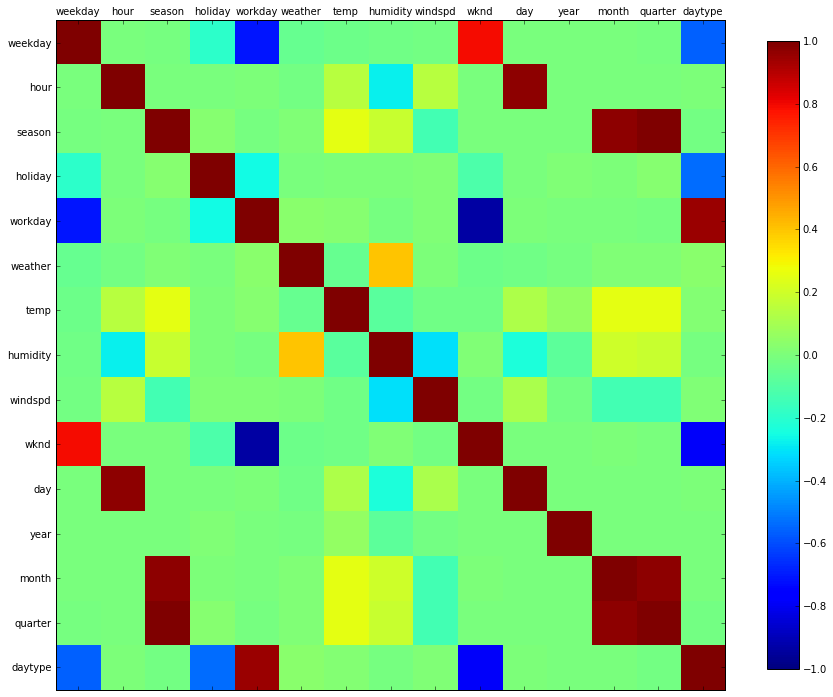

In [34]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
#names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
#data = pandas.read_csv(url, names=names)

variables = ['weekday', 'hour', 'season', 'holiday', 'workday', 
             'weather', 'temp', 'humidity','windspd','wknd',
             'day','year','month','quarter','daytype']

ftd = np.copy(final_train_data)
ftd2 = np.delete(ftd,(2,3),1)

data = pd.DataFrame(data=ftd2, columns=variables)

correlations = data.corr()

# plot correlation matrix


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax,shrink=.75)
ticks = np.arange(0,15)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(variables)
ax.set_yticklabels(variables)
plt.show()

In [36]:
conv_train_data[0][-2]

13.0